# A Diffusion Model from Scratch in Pytorch

In this notebook I want to build a very simple (as few code as possible) Diffusion Model for generating car images. I will explain all the theoretical details in the YouTube video.


**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)


## Investigating the dataset

As dataset we use the StandordCars Dataset, which consists of around 8000 images in the train set. Let's see if this is enough to get good results ;-)

In [68]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES']="2"

In [69]:


# def show_images(datset, num_samples=20, cols=4):
#     """ Plots some samples from the dataset """
#     plt.figure(figsize=(15,15))
#     for i, img in enumerate(data):
#         if i == num_samples:
#             break
#         plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
#         plt.imshow(img[0])

# data = torchvision.datasets.StanfordCars(root=".", download=True)
# show_images(data)

Later in this notebook we will do some additional modifications to this dataset, for example make the images smaller, convert them to tensors ect.

# Building the Diffusion Model


## Step 1: The forward process = Noise scheduler




We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually.

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

In [70]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
from tqdm import tqdm

DATA_DIR_PATH = "dataset"
DATA_PATH = os.path.join(DATA_DIR_PATH, 'animal-faces')
DATA_URL = 'https://www.kaggle.com/datasets/andrewmvd/animal-faces/download?datasetVersionNumber=1'
device = torch.device("cuda")
cpu_device = torch.device("cpu")

class AnimalfaceDataset(Dataset):
    def __init__(self, transform, type='train', label_dict = {"dog":0, "cat":1, "wild":2} , 
                 img_width=128, debug=False) -> None:
        self.transform = transform
        # self.root_dir specifies weather you are at afhq/train or afhq/val directory
        self.label_dict = label_dict
        self.root_dir = os.path.join(DATA_PATH, type)
        assert os.path.exists(self.root_dir), "Check for the dataset, it is not where it should be. If not present, you can download it by clicking above DATA_URL"
        subdir = os.listdir(self.root_dir)
        self.image_names = []
        
        for category in subdir:
            subdir_path = os.path.join(self.root_dir, category)
            self.image_names+=os.listdir(subdir_path)
        
        if debug:
            self.image_names = self.image_names[:256]
        self.img_arr = torch.zeros((len(self.image_names), 3, img_width ,img_width))
        self.labels = torch.zeros(len(self.image_names))
            
        for i,img_name in enumerate(tqdm(self.image_names)):
            label = self.label_dict[img_name.split("_")[1]]
            img_path = os.path.join(self.root_dir, img_name.split("_")[1], img_name)
            # Load image and convert it to RGB
            img = Image.open(img_path).convert('RGB')
            # Apply transformations to the image
            img = self.transform(img)
            self.img_arr[i] = img
            self.labels[i] = label
        
            
    def __getitem__(self, idx):
        return self.img_arr[idx], self.labels[idx]
    
    def __len__(self):
        return len(self.image_names)

In [71]:
width = 128
train_transform = transforms.Compose([transforms.Resize((width,width)), 
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=[0.5,], std=[0.5,])]) # trick: -1 to 1

In [ ]:
debug=0
train_data = AnimalfaceDataset(transform=train_transform, img_width=width, debug=debug)

 39%|███████████████████████████████▌                                                | 5766/14630 [17:44<34:48,  4.24it/s]

In [ ]:
# val_transform = train_transform
# val_data = AnimalfaceDataset(transform=val_transform, type="val", img_width=width, debug=debug)

In [ ]:
BATCH_SIZE = 64
# val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
from torchvision.utils import save_image, make_grid

def plot_grid(generated_grid, title=None):
    if title:
        plt.title(title)
    plt.axis("off")
    grid = generated_grid.permute(1,2,0).detach().to(cpu_device).numpy()
    grid = (grid + 1)/2 # convert (-1,1) to (0,1)
    plt.imshow(grid)

def gan_plot_grid(model,n_grid, z=None, title="GAN", save_name=None):
    if z == None:
        z = torch.randn((n_grid*n_grid, z_dim, 1, 1)).to(device)
    imgs = model(z)
    generated_grid = make_grid(imgs, nrow=n_grid)
    plt.figure(figsize=(n_grid,n_grid))
    plot_grid(generated_grid, title=title);
    if save_name:
        plt.savefig(f"bi-gan/figs/{save_name}.png")
    plt.show()

In [ ]:
imgs = next(iter(train_loader))[0][:25]
grid = make_grid(imgs, 5)
plot_grid(grid, title=f"{width}X{width}")

In [ ]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 4000
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

Let's test it on our dataset ...

In [ ]:
from torchvision import transforms


# data = load_transformed_dataset()
# dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data = train_data
dataloader = train_loader

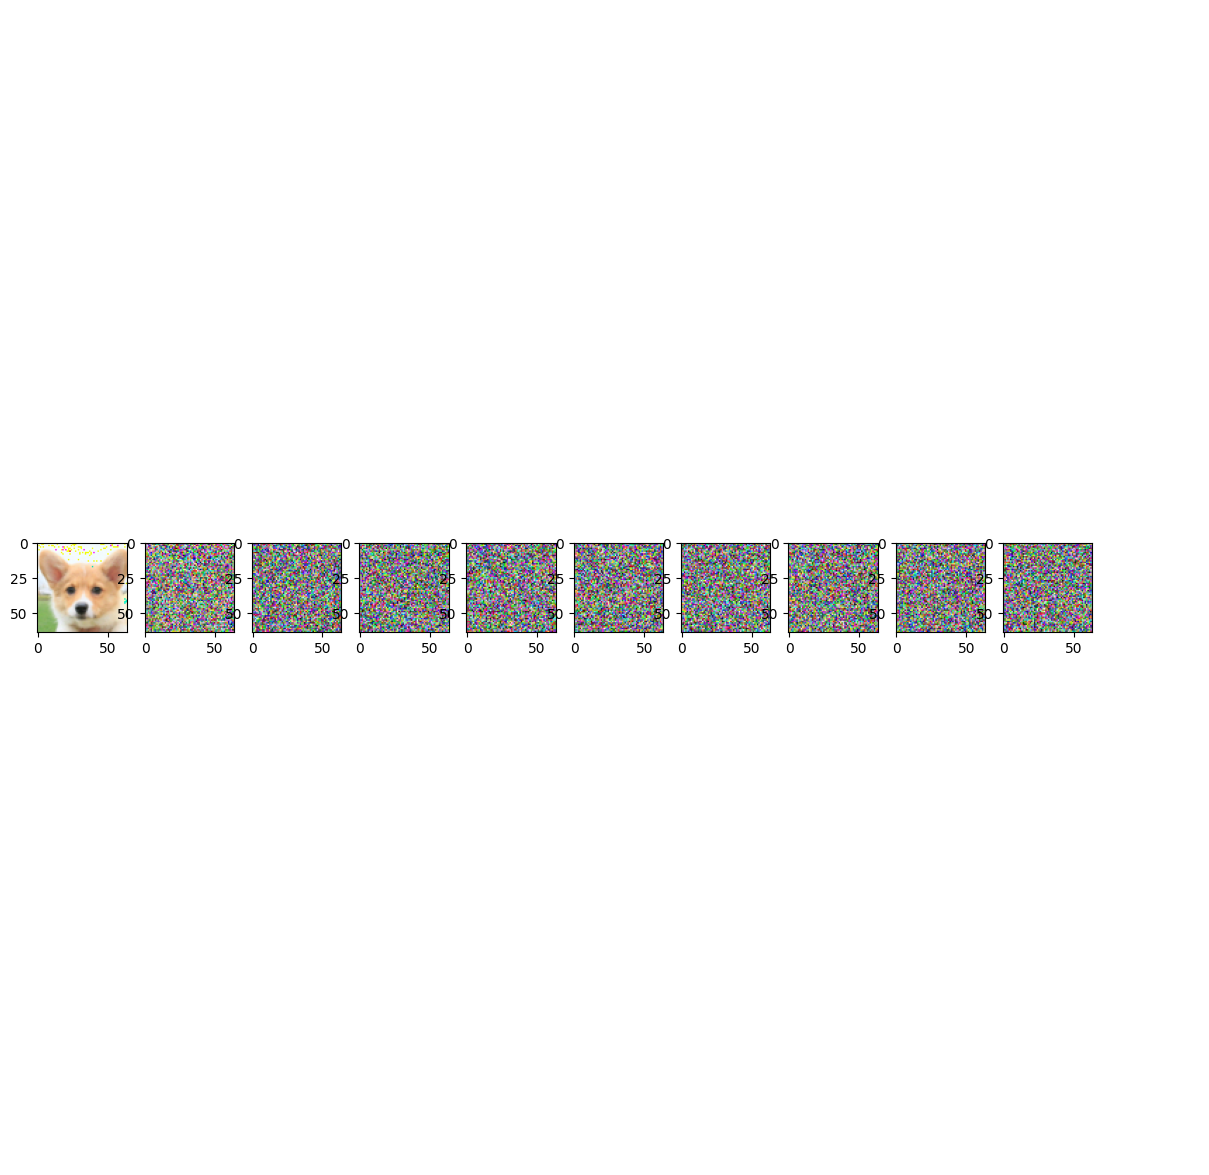

In [27]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

## Step 2: The backward process = U-Net



For a great introduction to UNets, have a look at this post: https://amaarora.github.io/2020/09/13/unet.html.


**Key Takeaways**:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed


In [28]:
# from torch import nn
# import math


# class Block(nn.Module):
#     def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
#         super().__init__()
#         self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
#         if up:
#             self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
#             self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
#         else:
#             self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
#             self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
#         self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
#         self.bnorm1 = nn.BatchNorm2d(out_ch)
#         self.bnorm2 = nn.BatchNorm2d(out_ch)
#         self.relu  = nn.ReLU()

#     def forward(self, x, t, ):
#         # First Conv
#         h = self.bnorm1(self.relu(self.conv1(x)))
#         # Time embedding
#         time_emb = self.relu(self.time_mlp(t))
#         # Extend last 2 dimensions
#         time_emb = time_emb[(..., ) + (None, ) * 2]
#         # Add time channel
#         h = h + time_emb
#         # Second Conv
#         h = self.bnorm2(self.relu(self.conv2(h)))
#         # Down or Upsample
#         return self.transform(h)


# class SinusoidalPositionEmbeddings(nn.Module):
#     def __init__(self, dim):
#         super().__init__()
#         self.dim = dim

#     def forward(self, time):
#         device = time.device
#         half_dim = self.dim // 2
#         embeddings = math.log(10000) / (half_dim - 1)
#         embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
#         embeddings = time[:, None] * embeddings[None, :]
#         embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
#         # TODO: Double check the ordering here
#         return embeddings


# class SimpleUnet(nn.Module):
#     """
#     A simplified variant of the Unet architecture.
#     """
#     def __init__(self):
#         super().__init__()
#         image_channels = 3
#         down_channels = (64, 128, 256, 512, 1024)
#         up_channels = (1024, 512, 256, 128, 64)
#         out_dim = 3
#         time_emb_dim = 32

#         # Time embedding
#         self.time_mlp = nn.Sequential(
#                 SinusoidalPositionEmbeddings(time_emb_dim),
#                 nn.Linear(time_emb_dim, time_emb_dim),
#                 nn.ReLU()
#             )

#         # Initial projection
#         self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

#         # Downsample
#         self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
#                                     time_emb_dim) \
#                     for i in range(len(down_channels)-1)])
#         # Upsample
#         self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
#                                         time_emb_dim, up=True) \
#                     for i in range(len(up_channels)-1)])

#         # Edit: Corrected a bug found by Jakub C (see YouTube comment)
#         self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

#     def forward(self, x, timestep):
#         # Embedd time
#         t = self.time_mlp(timestep)
#         # Initial conv
#         x = self.conv0(x)
#         # Unet
#         residual_inputs = []
#         for down in self.downs:
#             x = down(x, t)
#             residual_inputs.append(x)
#         for up in self.ups:
#             residual_x = residual_inputs.pop()
#             # Add residual x as additional channels
#             x = torch.cat((x, residual_x), dim=1)
#             x = up(x, t)
#         return self.output(x)

# model = SimpleUnet()
# print("Num params: ", sum(p.numel() for p in model.parameters()))
# model


**Further improvements that can be implemented:**
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization
- GroupNormalization
- Attention
- ...

In [ ]:
"""
Various utilities for neural networks.
"""

import math

import torch as th
import torch.nn as nn
import torch.nn.functional as F


class GroupNorm32(nn.GroupNorm):
    def __init__(self, num_groups, num_channels, swish, eps=1e-5):
        super().__init__(num_groups=num_groups, num_channels=num_channels, eps=eps)
        self.swish = swish

    def forward(self, x):
        y = super().forward(x.float()).to(x.dtype)
        if self.swish == 1.0:
            y = F.silu(y)
        elif self.swish:
            y = y * F.sigmoid(y * float(self.swish))
        return y


def conv_nd(dims, *args, **kwargs):
    """
    Create a 1D, 2D, or 3D convolution module.
    """
    if dims == 1:
        return nn.Conv1d(*args, **kwargs)
    elif dims == 2:
        return nn.Conv2d(*args, **kwargs)
    elif dims == 3:
        return nn.Conv3d(*args, **kwargs)
    raise ValueError(f"unsupported dimensions: {dims}")


def linear(*args, **kwargs):
    """
    Create a linear module.
    """
    return nn.Linear(*args, **kwargs)


def avg_pool_nd(dims, *args, **kwargs):
    """
    Create a 1D, 2D, or 3D average pooling module.
    """
    if dims == 1:
        return nn.AvgPool1d(*args, **kwargs)
    elif dims == 2:
        return nn.AvgPool2d(*args, **kwargs)
    elif dims == 3:
        return nn.AvgPool3d(*args, **kwargs)
    raise ValueError(f"unsupported dimensions: {dims}")


def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module


def scale_module(module, scale):
    """
    Scale the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().mul_(scale)
    return module


def normalization(channels, swish=0.0):
    """
    Make a standard normalization layer, with an optional swish activation.

    :param channels: number of input channels.
    :return: an nn.Module for normalization.
    """
    return GroupNorm32(num_channels=channels, num_groups=32, swish=swish)


def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = th.exp(
        -math.log(max_period) * th.arange(start=0, end=half, dtype=th.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = th.cat([th.cos(args), th.sin(args)], dim=-1)
    if dim % 2:
        embedding = th.cat([embedding, th.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

In [ ]:
import math
from abc import abstractmethod

import torch as th
import torch.nn as nn
import torch.nn.functional as F


class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb, encoder_out=None):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            elif isinstance(layer, AttentionBlock):
                x = layer(x, encoder_out)
            else:
                x = layer(x)
        return x


class Upsample(nn.Module):
    """
    An upsampling layer with an optional convolution.

    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 upsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2, out_channels=None):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.dims = dims
        if use_conv:
            self.conv = conv_nd(dims, self.channels, self.out_channels, 3, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.dims == 3:
            x = F.interpolate(x, (x.shape[2], x.shape[3] * 2, x.shape[4] * 2), mode="nearest")
        else:
            x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x


class Downsample(nn.Module):
    """
    A downsampling layer with an optional convolution.

    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 downsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2, out_channels=None):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.dims = dims
        stride = 2 if dims != 3 else (1, 2, 2)
        if use_conv:
            self.op = conv_nd(dims, self.channels, self.out_channels, 3, stride=stride, padding=1)
        else:
            assert self.channels == self.out_channels
            self.op = avg_pool_nd(dims, kernel_size=stride, stride=stride)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class ResBlock(TimestepBlock):
    """
    A residual block that can optionally change the number of channels.

    :param channels: the number of input channels.
    :param emb_channels: the number of timestep embedding channels.
    :param dropout: the rate of dropout.
    :param out_channels: if specified, the number of out channels.
    :param use_conv: if True and out_channels is specified, use a spatial
        convolution instead of a smaller 1x1 convolution to change the
        channels in the skip connection.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param use_checkpoint: if True, use gradient checkpointing on this module.
    :param up: if True, use this block for upsampling.
    :param down: if True, use this block for downsampling.
    """

    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
        use_conv=False,
        use_scale_shift_norm=False,
        dims=2,
        use_checkpoint=False,
        up=False,
        down=False,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_checkpoint = use_checkpoint
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            normalization(channels, swish=1.0),
            nn.Identity(),
            conv_nd(dims, channels, self.out_channels, 3, padding=1),
        )

        self.updown = up or down

        if up:
            self.h_upd = Upsample(channels, False, dims)
            self.x_upd = Upsample(channels, False, dims)
        elif down:
            self.h_upd = Downsample(channels, False, dims)
            self.x_upd = Downsample(channels, False, dims)
        else:
            self.h_upd = self.x_upd = nn.Identity()

        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            linear(
                emb_channels,
                2 * self.out_channels if use_scale_shift_norm else self.out_channels,
            ),
        )
        self.out_layers = nn.Sequential(
            normalization(self.out_channels, swish=0.0 if use_scale_shift_norm else 1.0),
            nn.SiLU() if use_scale_shift_norm else nn.Identity(),
            nn.Dropout(p=dropout),
            zero_module(conv_nd(dims, self.out_channels, self.out_channels, 3, padding=1)),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = conv_nd(dims, channels, self.out_channels, 3, padding=1)
        else:
            self.skip_connection = conv_nd(dims, channels, self.out_channels, 1)

    def forward(self, x, emb):
        """
        Apply the block to a Tensor, conditioned on a timestep embedding.

        :param x: an [N x C x ...] Tensor of features.
        :param emb: an [N x emb_channels] Tensor of timestep embeddings.
        :return: an [N x C x ...] Tensor of outputs.
        """
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_upd(h)
            x = self.x_upd(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = th.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)
        return self.skip_connection(x) + h


class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.

    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    """

    def __init__(
        self,
        channels,
        num_heads=1,
        num_head_channels=-1,
        use_checkpoint=False,
        encoder_channels=None,
    ):
        super().__init__()
        self.channels = channels
        if num_head_channels == -1:
            self.num_heads = num_heads
        else:
            assert (
                channels % num_head_channels == 0
            ), f"q,k,v channels {channels} is not divisible by num_head_channels {num_head_channels}"
            self.num_heads = channels // num_head_channels
        self.use_checkpoint = use_checkpoint
        self.norm = normalization(channels, swish=0.0)
        self.qkv = conv_nd(1, channels, channels * 3, 1)
        self.attention = QKVAttention(self.num_heads)

        if encoder_channels is not None:
            self.encoder_kv = conv_nd(1, encoder_channels, channels * 2, 1)
        self.proj_out = zero_module(conv_nd(1, channels, channels, 1))

    def forward(self, x, encoder_out=None):
        b, c, *spatial = x.shape
        qkv = self.qkv(self.norm(x).view(b, c, -1))
        if encoder_out is not None:
            encoder_out = self.encoder_kv(encoder_out)
            h = self.attention(qkv, encoder_out)
        else:
            h = self.attention(qkv)
        h = self.proj_out(h)
        return x + h.reshape(b, c, *spatial)


class QKVAttention(nn.Module):
    """
    A module which performs QKV attention. Matches legacy QKVAttention + input/ouput heads shaping
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv, encoder_kv=None):
        """
        Apply QKV attention.

        :param qkv: an [N x (H * 3 * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.reshape(bs * self.n_heads, ch * 3, length).split(ch, dim=1)
        if encoder_kv is not None:
            assert encoder_kv.shape[1] == self.n_heads * ch * 2
            ek, ev = encoder_kv.reshape(bs * self.n_heads, ch * 2, -1).split(ch, dim=1)
            k = th.cat([ek, k], dim=-1)
            v = th.cat([ev, v], dim=-1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = th.einsum(
            "bct,bcs->bts", q * scale, k * scale
        )  # More stable with f16 than dividing afterwards
        weight = th.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = th.einsum("bts,bcs->bct", weight, v)
        return a.reshape(bs, -1, length)


class UNetModel(nn.Module):
    """
    The full UNet model with attention and timestep embedding.

    :param in_channels: channels in the input Tensor.
    :param model_channels: base channel count for the model.
    :param out_channels: channels in the output Tensor.
    :param num_res_blocks: number of residual blocks per downsample.
    :param attention_resolutions: a collection of downsample rates at which
        attention will take place. May be a set, list, or tuple.
        For example, if this contains 4, then at 4x downsampling, attention
        will be used.
    :param dropout: the dropout probability.
    :param channel_mult: channel multiplier for each level of the UNet.
    :param conv_resample: if True, use learned convolutions for upsampling and
        downsampling.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param num_classes: if specified (as an int), then this model will be
        class-conditional with `num_classes` classes.
    :param use_checkpoint: use gradient checkpointing to reduce memory usage.
    :param num_heads: the number of attention heads in each attention layer.
    :param num_heads_channels: if specified, ignore num_heads and instead use
                               a fixed channel width per attention head.
    :param num_heads_upsample: works with num_heads to set a different number
                               of heads for upsampling. Deprecated.
    :param use_scale_shift_norm: use a FiLM-like conditioning mechanism.
    :param resblock_updown: use residual blocks for up/downsampling.
    """

    def __init__(
        self,
        in_channels,
        model_channels,
        out_channels,
        num_res_blocks,
        attention_resolutions,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
        conv_resample=True,
        dims=2,
        num_classes=None,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        resblock_updown=False,
        encoder_channels=None,
    ):
        super().__init__()

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_classes = num_classes
        self.use_checkpoint = use_checkpoint
        self.dtype = th.float16 if use_fp16 else th.float32
        self.num_heads = num_heads
        self.num_head_channels = num_head_channels
        self.num_heads_upsample = num_heads_upsample

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            linear(model_channels, time_embed_dim),
            nn.SiLU(),
            linear(time_embed_dim, time_embed_dim),
        )

        if self.num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_embed_dim)

        ch = input_ch = int(channel_mult[0] * model_channels)
        self.input_blocks = nn.ModuleList(
            [TimestepEmbedSequential(conv_nd(dims, in_channels, ch, 3, padding=1))]
        )
        self._feature_size = ch
        input_block_chans = [ch]
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        out_channels=int(mult * model_channels),
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(mult * model_channels)
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads,
                            num_head_channels=num_head_channels,
                            encoder_channels=encoder_channels,
                        )
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(
                    TimestepEmbedSequential(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            down=True,
                        )
                        if resblock_updown
                        else Downsample(ch, conv_resample, dims=dims, out_channels=out_ch)
                    )
                )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch

        self.middle_block = TimestepEmbedSequential(
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            AttentionBlock(
                ch,
                use_checkpoint=use_checkpoint,
                num_heads=num_heads,
                num_head_channels=num_head_channels,
                encoder_channels=encoder_channels,
            ),
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
        )
        self._feature_size += ch

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [
                    ResBlock(
                        ch + ich,
                        time_embed_dim,
                        dropout,
                        out_channels=int(model_channels * mult),
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(model_channels * mult)
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads_upsample,
                            num_head_channels=num_head_channels,
                            encoder_channels=encoder_channels,
                        )
                    )
                if level and i == num_res_blocks:
                    out_ch = ch
                    layers.append(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            up=True,
                        )
                        if resblock_updown
                        else Upsample(ch, conv_resample, dims=dims, out_channels=out_ch)
                    )
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch

        self.out = nn.Sequential(
            normalization(ch, swish=1.0),
            nn.Identity(),
            zero_module(conv_nd(dims, input_ch, out_channels, 3, padding=1)),
        )
        self.use_fp16 = use_fp16


    def forward(self, x, timesteps, y=None):
        """
        Apply the model to an input batch.

        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param y: an [N] Tensor of labels, if class-conditional.
        :return: an [N x C x ...] Tensor of outputs.
        """
        assert (y is not None) == (
            self.num_classes is not None
        ), "must specify y if and only if the model is class-conditional"

        hs = []
        pos_emb = timestep_embedding(timesteps, self.model_channels)
        emb = self.time_embed(pos_emb)

        if self.num_classes is not None:
            assert y.shape == (x.shape[0],)
            emb = emb + self.label_emb(y)

        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)

        h = self.middle_block(h, emb)
        
        for module in self.output_blocks:
            h = th.cat([h, hs.pop()], dim=1)
            h = module(h, emb)
        h = h.type(x.dtype)
        return self.out(h)

In [48]:
# image_size=width
# num_channels=128
# num_res_blocks=3
# num_heads=4
# num_heads_upsample=-1
# attention_resolutions="16,8"
# dropout=0.0
# learn_sigma=False
# sigma_small=False
# class_cond=False
# diffusion_steps=4000
# noise_schedule="linear"
# timestep_respacing=""
# use_kl=False
# predict_xstart=False
# rescale_timesteps=True
# rescale_learned_sigmas=True
# use_checkpoint=False
# use_scale_shift_norm=True

In [64]:
channel_mult = (1, 1, 2, 3, 4)
NUM_CLASSES = 3
attention_ds = []
num_channels = 128
num_res_blocks = 3
num_heads = 4
num_heads_upsample = -1
use_scale_shift_norm = True
use_checkpoint = False
dropout = 0.1
class_cond = False
attention_resolutions = [32,16,8]
for res in attention_resolutions:
    attention_ds.append(image_size // int(res))

model = UNetModel(
        in_channels=3,
        model_channels=num_channels,
        out_channels=3,
        num_res_blocks=num_res_blocks,
        attention_resolutions=tuple(attention_ds),
        dropout=dropout,
        channel_mult=channel_mult,
        num_classes=(NUM_CLASSES if class_cond else None),
        use_checkpoint=use_checkpoint,
        num_heads=num_heads,
        num_heads_upsample=num_heads_upsample,
        use_scale_shift_norm=use_scale_shift_norm,
    )
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  92025731


UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): Identity()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=256, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.0, inplace=False)
          (3): Conv2d(128, 128, kernel_size=(3

## Step 3: The loss



**Key Takeaways:**
- After some maths we end up with a very simple loss function
- There are other possible choices like L2 loss ect.


In [65]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## Sampling
- Without adding @torch.no_grad() we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation
- Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process

In [66]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

## Training

Epoch 1/100 | step 227 Loss: 0.07864058017730713 
Epoch 2/100 | step 227 Loss: 0.06120694801211357 


0it [06:53, ?it/s]


Epoch 3/100 | step 227 Loss: 0.05928540229797363 
Epoch 4/100 | step 227 Loss: 0.05093647167086601 
Epoch 5/100 | step 227 Loss: 0.050846170634031296 


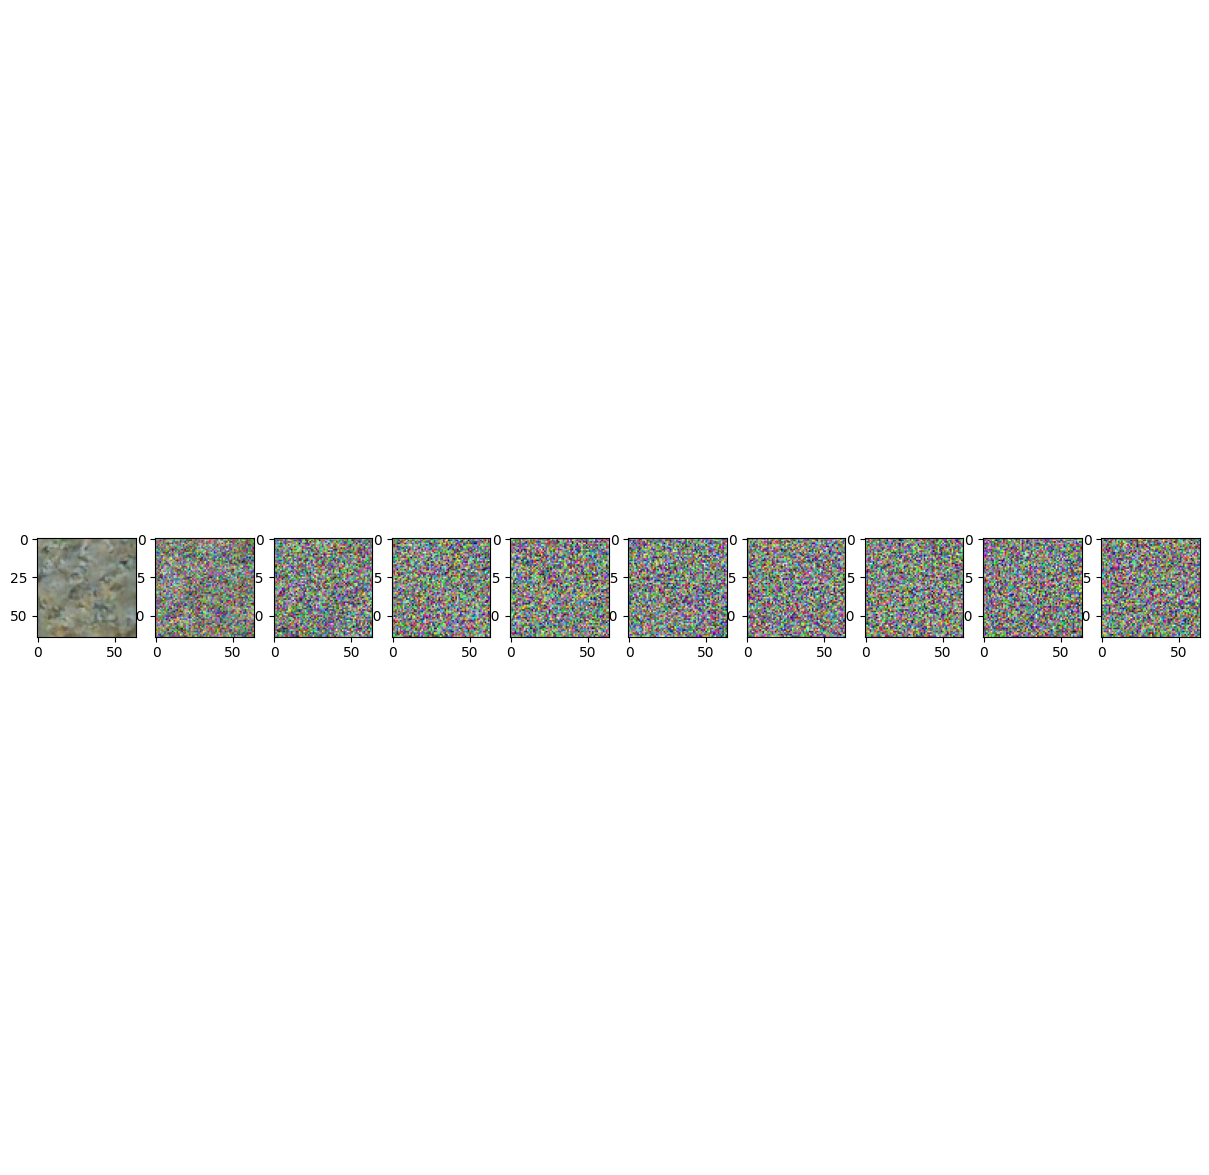

Epoch 6/100 | step 227 Loss: 0.061972253024578094 
Epoch 7/100 | step 227 Loss: 0.07141342759132385 
Epoch 8/100 | step 227 Loss: 0.05473937839269638 
Epoch 9/100 | step 227 Loss: 0.06651803106069565 
Epoch 10/100 | step 227 Loss: 0.05759212374687195 
Epoch 12/100 | step 227 Loss: 0.06151294335722923 
Epoch 13/100 | step 227 Loss: 0.037937138229608536 
Epoch 14/100 | step 227 Loss: 0.039618801325559616 
Epoch 15/100 | step 227 Loss: 0.049411527812480927 


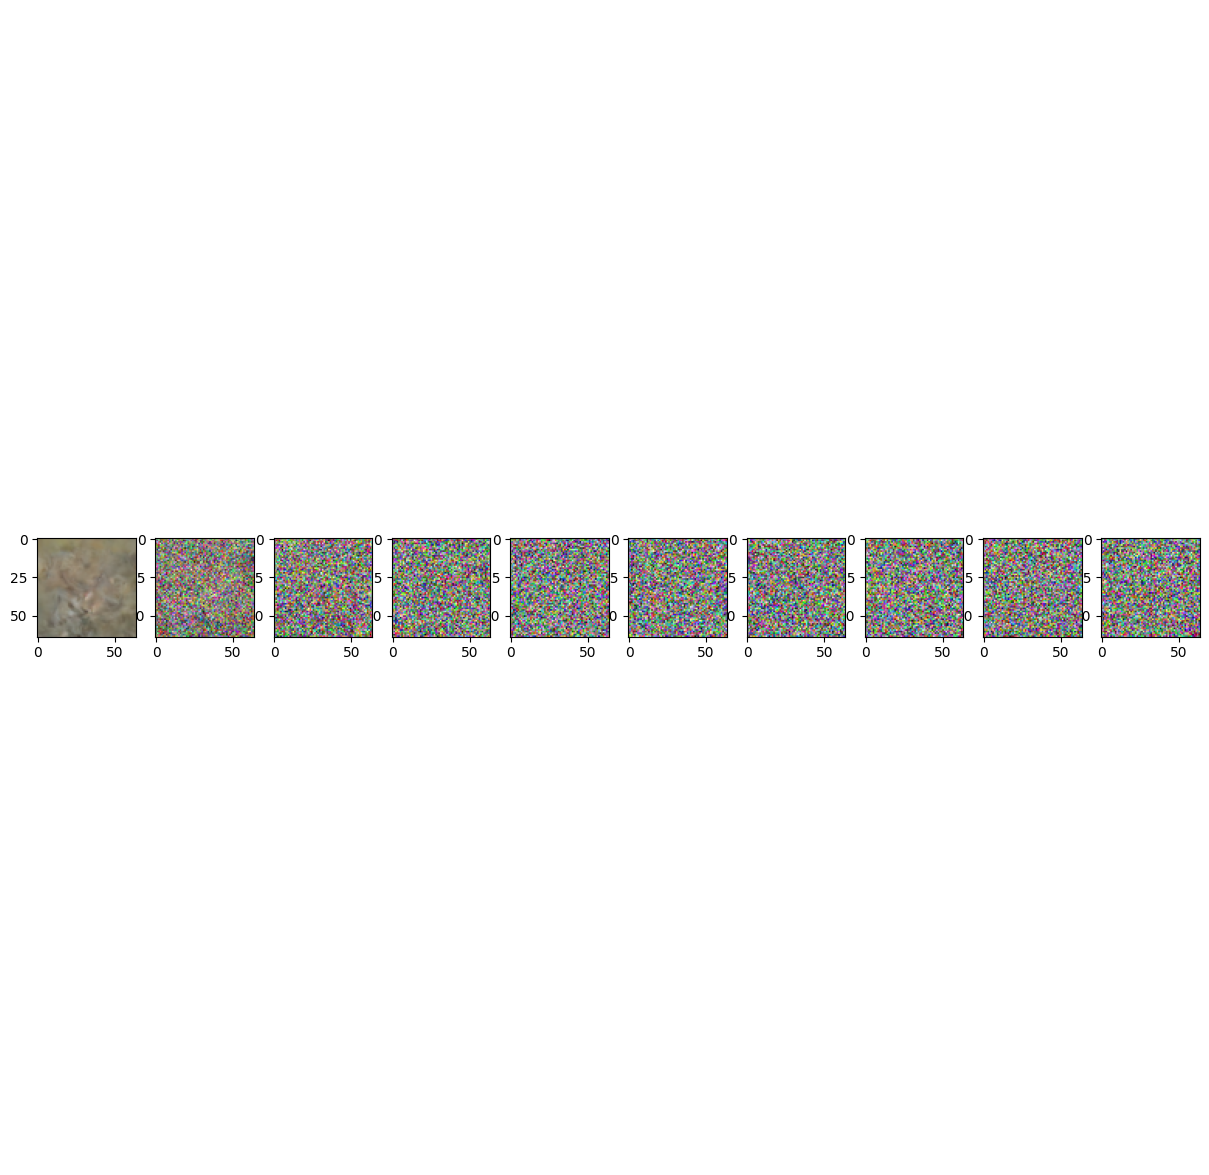

Epoch 16/100 | step 227 Loss: 0.04807545989751816 
Epoch 17/100 | step 227 Loss: 0.05727362632751465 


KeyboardInterrupt: 

In [67]:
from torch.optim import Adam

device = "cuda"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs} | step {step:03d} Loss: {loss.item()} ")
        
    if (epoch+1)%5 == 0:
        sample_plot_image()

In [53]:
tq = tqdm(enumerate(dataloader))

0it [00:00, ?it/s]